<a href="https://colab.research.google.com/github/colin-hehir/Forecasting-of-CO2-Emissions/blob/main/Model_Selection_and_Evaluation_World_Predicted_CO2_Emissions_in_2030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original CO₂ and Greenhouse Gas Emissions data available at: 'https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions' (accessed on 18 February2022)

Time Series Forecasting using Dart code available at: https://towardsdatascience.com/darts-swiss-knife-for-time-series-forecasting-in-python-f37bb74c126 (accessed on 26 March 2022).

Ensemble Forecasts of Time Series using Dart available at: https://towardsdatascience.com/wisdom-of-the-forecaster-crowd-f70b398f190b (accessed on 29 March 2022).


In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
from pandas import DataFrame, Series
downloaded = drive.CreateFile({'id':'184a-iMGRv-aAsHjVJbXwRo3AtfxW5h7I'}) 
downloaded.GetContentFile('co2-forecast.csv')  
co2_forecast_data = pd.read_csv('co2-forecast.csv')
print(co2_forecast_data.describe())

                co2
count    271.000000
mean    6260.236797
std     9943.308119
min        9.351000
25%       49.537500
50%     1009.675000
75%     6556.711000
max    36702.503000


In [ ]:
!pip install darts
!pip install u8darts[all]
!pip install u8darts[fbprophet]
!pip install u8darts[prophet]
!pip install prophet
!pip install fbprophet
!pip install u8darts[pmdarima]
!pip install u8darts[torch]

     |████████████████████████████████| 359 kB 5.0 MB/s 
     |████████████████████████████████| 11.2 MB 50.9 MB/s 
     |████████████████████████████████| 793 kB 50.7 MB/s 
     |████████████████████████████████| 172 kB 65.5 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 582 kB 46.1 MB/s 
     |████████████████████████████████| 9.8 MB 29.8 MB/s 
     |████████████████████████████████| 1.4 MB 33.6 MB/s 
     |████████████████████████████████| 381 kB 27.4 MB/s 
     |████████████████████████████████| 899 kB 50.8 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
     |████████████████████████████████| 136 kB 47.0 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 398 kB 45.4 MB/s 
     |████████████████████████████████| 1.1 MB 14.0 MB/s 
     |████████████████

     |████████████████████████████████| 359 kB 5.1 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
from darts import TimeSeries

In [ ]:
series = TimeSeries.from_dataframe(co2_forecast_data, 'year', 'co2')

In [ ]:
series

<TimeSeries (DataArray) (year: 271, component: 1, sample: 1)>
array([[[9.3510000e+00]],

       [[9.3510000e+00]],

       [[9.3540000e+00]],

       [[9.3540000e+00]],

       [[9.3580000e+00]],

       [[9.3620000e+00]],

       [[1.0006000e+01]],

       [[1.0010000e+01]],

       [[1.0014000e+01]],

       [[1.0017000e+01]],

...

       [[3.4468451e+04]],

       [[3.4974075e+04]],

       [[3.5283025e+04]],

       [[3.5534443e+04]],

       [[3.5496406e+04]],

       [[3.5452459e+04]],

       [[3.5925738e+04]],

       [[3.6646140e+04]],

       [[3.6702503e+04]],

       [[3.4807259e+04]]])
Coordinates:
  * year       (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2020-01-01
  * component  (component) object 'co2'
Dimensions without coordinates: sample

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from pandas import Timestamp

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import math as m


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mse, mae, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
train, val = series.split_after(pd.Timestamp("19900101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, end=series.end_time()),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
covariates = year_series
cov_train, cov_val = covariates.split_after(pd.Timestamp("19900101"))

In [ ]:
import time
t_start1 = time.perf_counter()


%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    RegressionEnsembleModel
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.utils import ModelMode  

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

TRACE = False  
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

TRAIN = 2000        # training until date AirPassengers

In [ ]:
!pip install matplotlib==3.1.1
import matplotlib.pyplot as plt

     |████████████████████████████████| 13.1 MB 1.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
u8darts 0.18.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.
nfoursid 1.0.0 requires matplotlib>=3.3, but you have matplotlib 3.1.1 which is incompatible.
darts 0.18.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


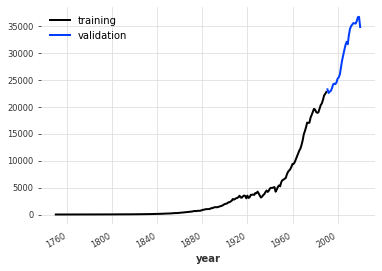

In [ ]:
train.plot(label="training")
val.plot(label="validation")

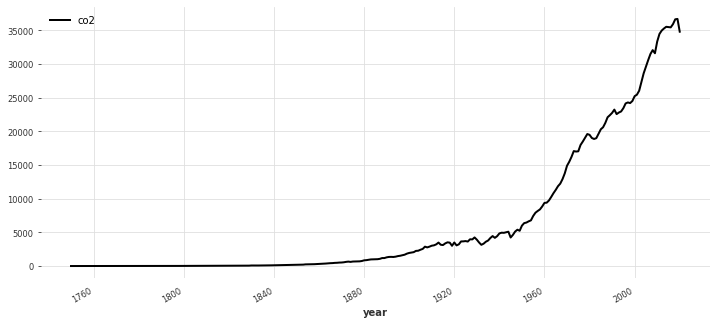

In [ ]:
plt.figure(100, figsize=(12, 5))
series.plot()

In [ ]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? False


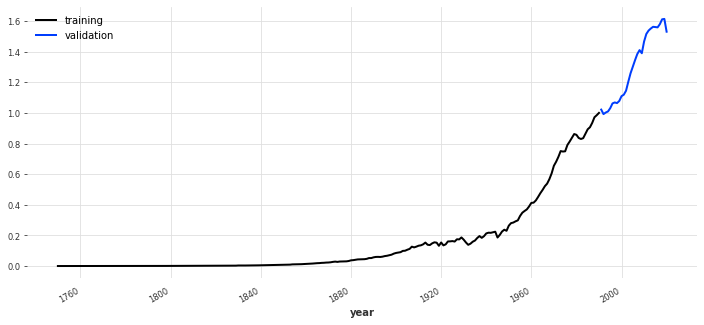

In [ ]:
plt.figure(101, figsize=(12, 5))
train_transformed.plot(label='training')
val_transformed.plot(label='validation')
plt.legend();

In [ ]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train_transformed)
    forecast = model.predict(len(val_transformed))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train_transformed)
            fc_seas = modelS.predict(len(val_transformed))
            forecast = fc_drift + fc_seas - train_transformed.last_value()


    # compute accuracy metrics and processing time
    res_mape = mape(val_transformed, forecast)
    res_mae = mae(val_transformed, forecast)
    res_r2 = r2_score(val_transformed, forecast)
    res_rmse = rmse(val_transformed, forecast)
    res_rmsle = rmsle(val_transformed, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

In [ ]:
# prepare Naive forecaster

m_naive = NaiveDrift()

In [ ]:
# prepare Exponential Smoothing forecaster

m_expon = ExponentialSmoothing(seasonal=None)

In [ ]:
# prepare Prophet forecaster

m_prophet = Prophet()    #frequency=mseas)

In [ ]:
# prepare ARIMA forecaster

y = np.asarray(series_transformed.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")

In [ ]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100

In [ ]:
is_seasonal

False

In [ ]:
# laundry list of forecasters to run

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet
   ]

In [ ]:
# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=None, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=None, seasonal_periods=0:0.28181758099998433sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.1292458170000259sec
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : BIC=-1567.223, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : BIC=-1482.784, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : BIC=-1510.371, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : BIC=-1576.132, Time=0.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=-1488.252, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : BIC=-1576.048, Time=0.63 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : BIC=-1570.468, Time=0.74 sec
 ARIMA(0,2,1)(0,0,0)[0]             : BIC=-1580.385, Time=0.76 sec
 ARIMA(1,2,1)(0,0,0)[0]             : BIC=-1580.977, Time=0.45 

In [ ]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,"ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=None, seasonal_periods=0",Theta(-0.1212121212121211),Auto-ARIMA,Naive drift model,Prophet
MAPE,5.477,6.863,5.556,16.480,6.617
MAE,0.072,0.085,0.074,0.240,0.096
R squared,-0.868,-0.806,-0.861,0.851,-0.702
RMSE,0.081,0.098,0.083,0.303,0.122
RMSLE,0.034,0.043,0.035,0.132,0.050
time,0.282,0.129,8.143,0.173,7.275


In [ ]:
# RUN the forecasters and tabulate their prediction accuracy and processing time - exclude the Naive forecast

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0 and i != 3: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,"ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=None, seasonal_periods=0",Theta(-0.1212121212121211),Auto-ARIMA,Prophet
MAPE,5.477,6.863,5.556,6.617
MAE,0.072,0.085,0.074,0.096
R squared,-0.868,-0.806,-0.861,-0.702
RMSE,0.081,0.098,0.083,0.122
RMSLE,0.034,0.043,0.035,0.050
time,0.282,0.129,8.143,7.275


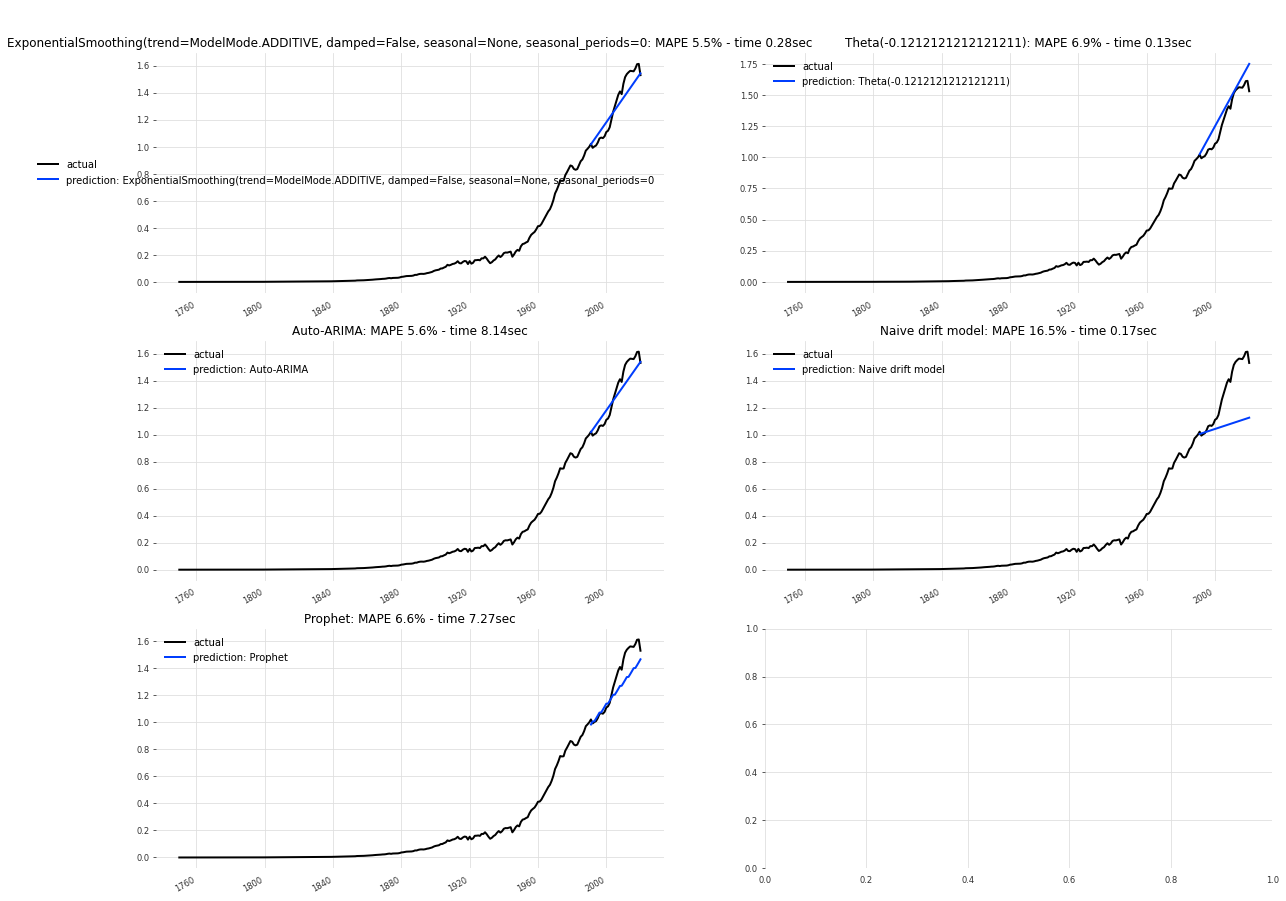

In [ ]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series_transformed.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()

In [ ]:
act = val_transformed

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]


Ljung-Box test for white-noise residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=None, seasonal_periods=0 : 1.56785913640409e-19
Theta(-0.1212121212121211) : 7.943605033457784e-05
Auto-ARIMA : 9.960745782057022e-20
Naive drift model : 1.4361728952270004e-21
Prophet : 8.676448513863957e-21

test for normality of residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=None, seasonal_periods=0 : 2.725876351878699e-05
Theta(-0.1212121212121211) : 0.377467131570839
Auto-ARIMA : 1.8938392495021538e-05
Naive drift model : 3.1486393515385086e-07
Prophet : 9.351404696681679e-07


[None, None, None, None, None]

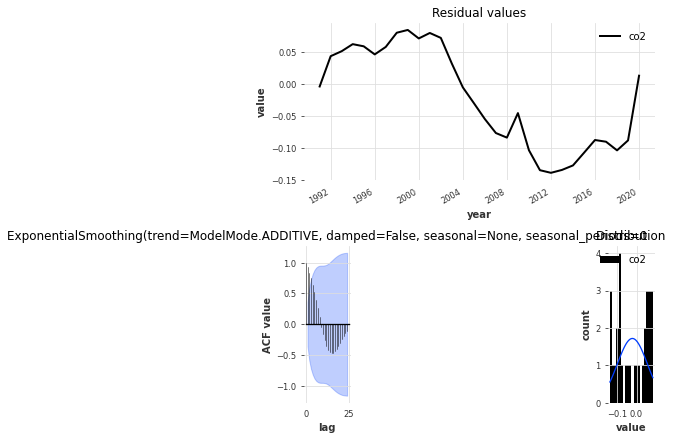

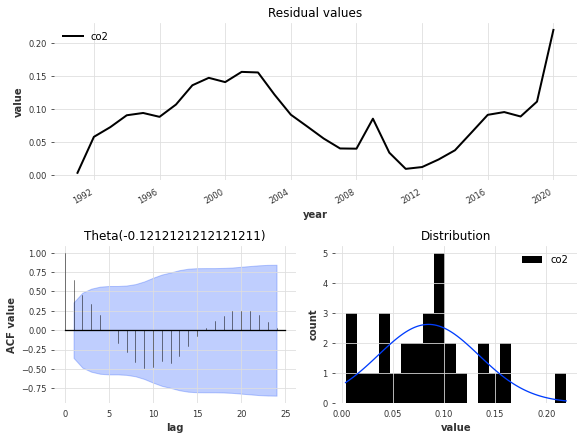

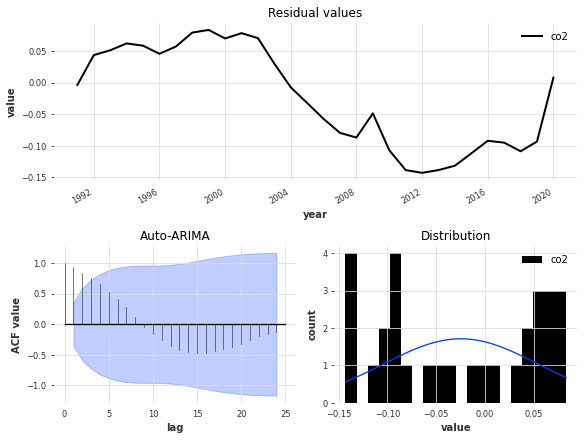

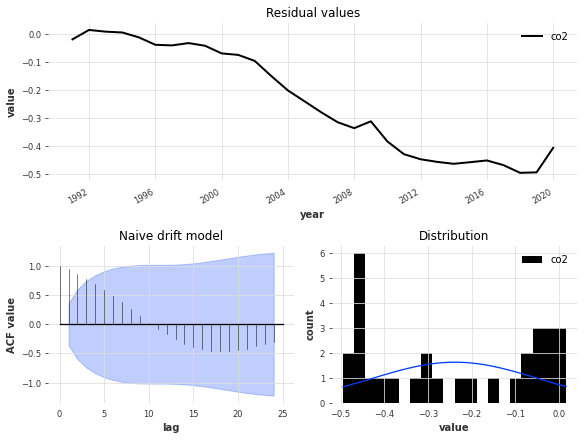

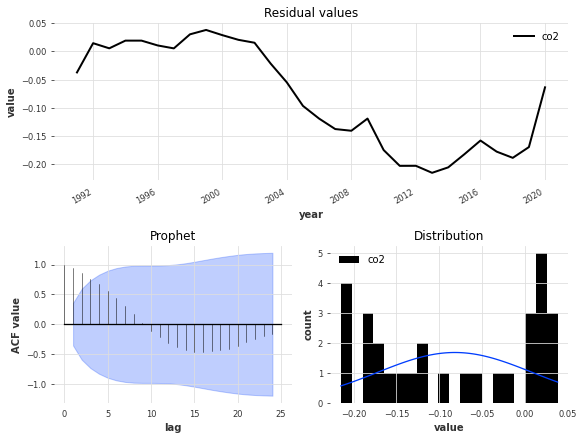

In [ ]:
# investigate the residuals in the validation dataset

act = val_transformed
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act

        #df_desc = pd.concat([df_desc, resid.describe()], axis=1)

        plot_residuals_analysis(resid);
        plt.title(str(m))

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train_transformed, val_transformed, models):
    t_start =  time.perf_counter()
    n_train = len(train_transformed)               # use 50 observation to train the ensemble model
    n_val = len(val_transformed)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[    Theta(best_theta), 
                                                        Prophet(), 
                                                        AutoARIMA(), 
                                                        NaiveDrift(), 
                                                        ExponentialSmoothing(
                                                                            seasonal=None)],
                                             regression_train_n_points=12)
                      



    ensemble_model.fit(train_transformed)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - val_transformed


    res_accuracy = accuracy_metrics(val_transformed, forecast, resid, t_start)


    # plot the ensemble forecast
    series_transformed.plot(label="actual")
    forecast.plot(label="Ensemble forecast")
    plt.title("MAPE = {:.2f}%".format(res_accuracy["MAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results

In [ ]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid, t_start):
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    res_mape = mape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    res_time = time.perf_counter() - t_start
    
    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2, 
        "se": res_sefc, "time":res_time}
    return res_accuracy

Ensemble of all 5 forecasters:


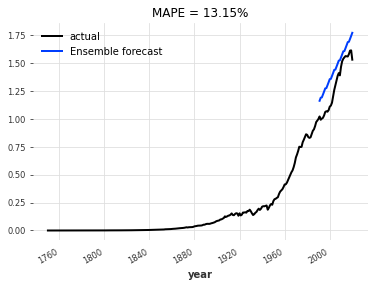

In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["Expon", "Theta", "ARIMA", "Naive", "Prophet", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 5 forecasters:")
res_ensemble = ensemble_eval(train_transformed, act, models2)

In [ ]:
# collect the accuracy metrics

df_acc2 = df_acc.copy()
df_acc2["avg"] = df_acc2.mean(axis=1)
df_acc2["Ensemble"] = pd.Series(res_ensemble[1])
df_acc2.columns = col_heads
df_acc2.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,Expon,Theta,ARIMA,Naive,Prophet,Ensemble
MAPE,5.477,6.863,5.556,6.617,6.128,13.148
MAE,0.072,0.085,0.074,0.096,0.082,nan
R squared,-0.868,-0.806,-0.861,-0.702,-0.809,nan
RMSE,0.081,0.098,0.083,0.122,0.096,0.170
RMSLE,0.034,0.043,0.035,0.050,0.041,nan
time,0.282,0.129,8.143,7.275,3.957,8.097


Text(0.5, 1.0, 'Ensemble forecast')

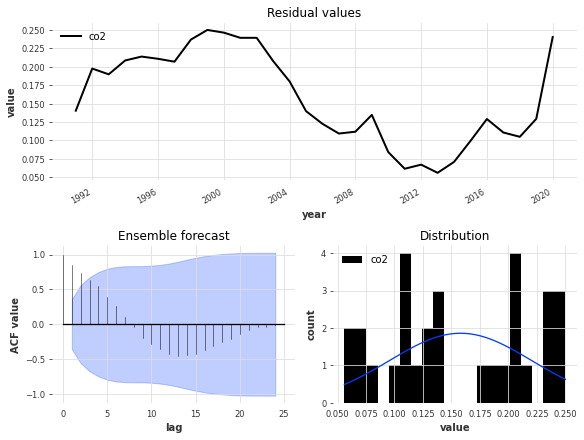

In [ ]:
#resid = res_ensemble[2]

resid = res_ensemble[0] - act
sr = resid.pd_series()
plot_residuals_analysis(resid);
plt.title("Ensemble forecast")

In [ ]:
resL = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
resN = normaltest(sr)[1]
   
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
print(resL)

print("\ntest for normality of residuals: p-value > alpha?")
print(resN)


Ljung-Box test for white-noise residuals: p-value > alpha?
1.2925192311048741e-14

test for normality of residuals: p-value > alpha?
0.004295798616812661


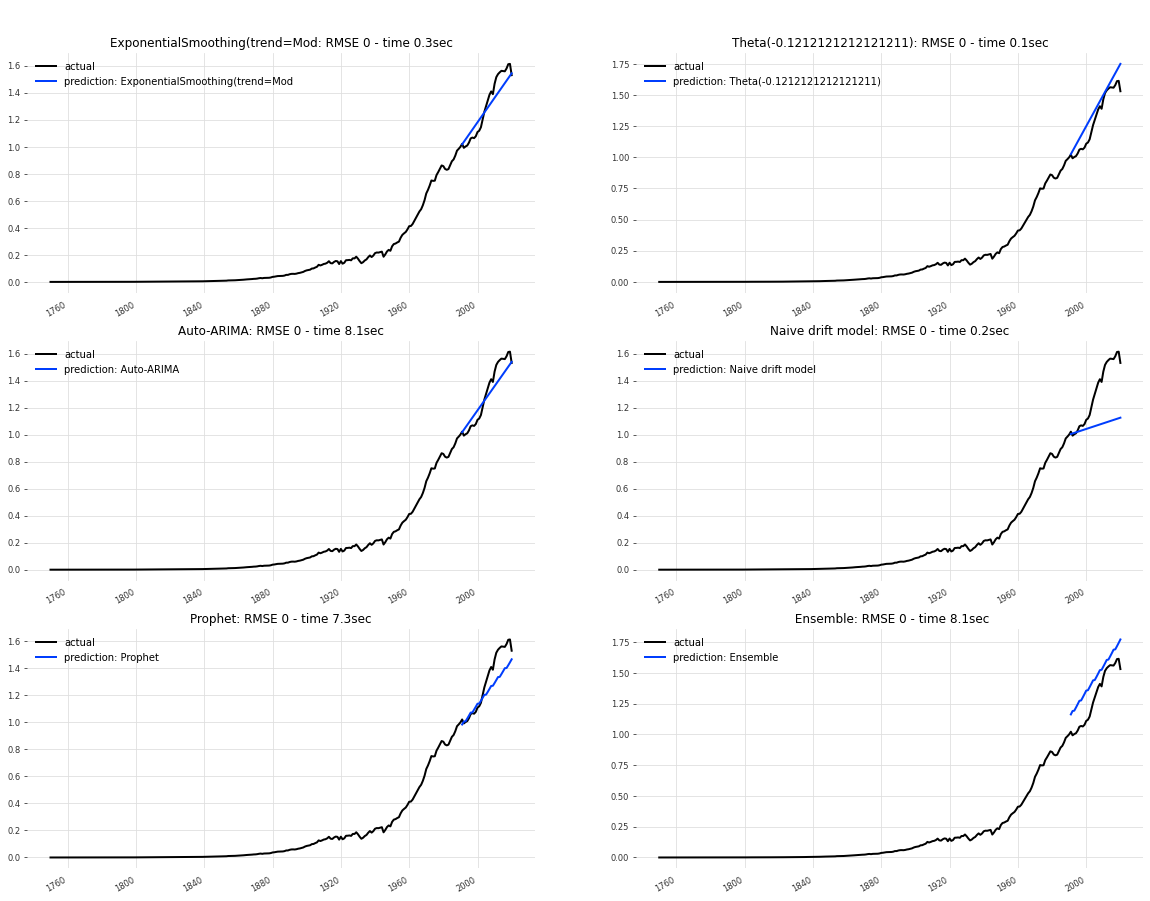

In [ ]:
# plot the forecast scenario, and now include the ensemble

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series_transformed.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m)[:30], ax=ax[i])
        rmse_model =  model_predictions[i][1]["RMSE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m)[:30] + ": RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
        ax[i].set_xlabel("")
        ax[i].legend()


# add the ensemble:
series_transformed.plot(label="actual", ax=ax[i+1])
res_ensemble[0].plot(label="prediction: Ensemble", ax=ax[i+1])
rmse_model =  res_ensemble[1]["RMSE"]
time_model =  res_ensemble[1]["time"]
ax[i+1].set_title("\n\n Ensemble: RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
ax[i+1].set_xlabel("")
ax[i+1].legend();

In [ ]:
model = m_expon
res2030 = model.fit(series_transformed)
forecast2030 = model.predict(10)

In [ ]:
forecast2030 

<TimeSeries (DataArray) (year: 10, component: 1, sample: 1)>
array([[[1.52490413]],

       [[1.51957224]],

       [[1.51424036]],

       [[1.50890848]],

       [[1.5035766 ]],

       [[1.49824472]],

       [[1.49291284]],

       [[1.48758096]],

       [[1.48224908]],

       [[1.4769172 ]]])
Coordinates:
  * year       (year) datetime64[ns] 2021-01-01 2022-01-01 ... 2030-01-01
  * component  (component) object 'co2'
Dimensions without coordinates: sample

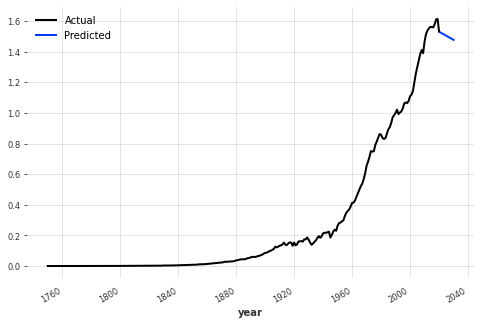

In [ ]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="Actual")
forecast2030.plot(label="Predicted")

In [ ]:
series_untransformed = transformer.inverse_transform(series_transformed)
forecast2030_untransformed = transformer.inverse_transform(forecast2030)

Text(0, 0.5, 'C02 Emissions')

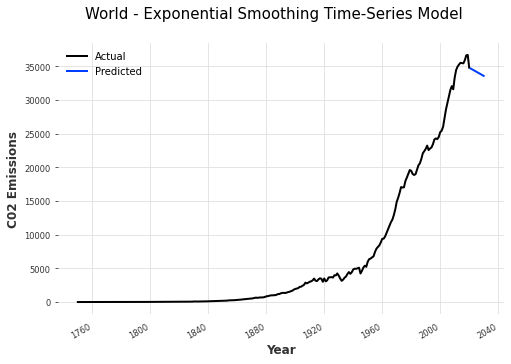

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.suptitle('World - Exponential Smoothing Time-Series Model', fontsize=15)
series_untransformed.plot(label="Actual")
forecast2030_untransformed.plot(label="Predicted")
plt.xlabel('Year', fontsize=12)
plt.ylabel('C02 Emissions', fontsize=12)

In [ ]:
forecast2030_untransformed

<TimeSeries (DataArray) (year: 10, component: 1, sample: 1)>
array([[[34686.01087278]],

       [[34564.76271189]],

       [[34443.51455101]],

       [[34322.26639013]],

       [[34201.01822925]],

       [[34079.77006836]],

       [[33958.52190748]],

       [[33837.2737466 ]],

       [[33716.02558571]],

       [[33594.77742483]]])
Coordinates:
  * year       (year) datetime64[ns] 2021-01-01 2022-01-01 ... 2030-01-01
  * component  (component) object 'co2'
Dimensions without coordinates: sample

**Predicted CO2 Emissions in 2030 from the World:** 33594.77742483

